# About
Implement clustering algorithms
1. K-Means
1. Heirarchical clustering
1. DBSCAN

## The Team
| Name| Student ID|
|------------|---------------|
|Cynthia Cai | 5625483 |
|Pratyush Kumar | 5359252|


# Imports

// add the imports to the cell below

In [1]:
import numpy as np 
import pandas as pd
from scipy.spatial import ConvexHull, distance_matrix
from sklearn.metrics.pairwise import euclidean_distances as eucDist
import glob
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

# Reading the dataset


From the readme for the xyz files, we know that:

Ground truth labels:
|File range|Label|
|--|--|
|    000 - 099: |building|
|    100 - 199: |car|
|    200 - 299: |fence|
|    300 - 399: |pole|
|    400 - 499: |tree|


workflow:

iterate through the files, and collect them in a dataframe

Use [this link](https://pandas.pydata.org/docs/reference/api/pandas.concat.html#pandas.concat) for concatenating the dataframes

In [2]:
xyzPath = './scene_objects/data/*.xyz'

dataPathsList = glob.glob(xyzPath)

In [3]:
allPointsDF= pd.DataFrame(columns=['x','y','z', 'fileNo', 'groundLabel'])
# featureDF = pd.DataFrame(columns=['Label' , 'convHull', median] )

def df_maker(df1, df2):
    return pd.concat([df1, df2], sort=False, ignore_index=True)

labelToGive = None
for path in dataPathsList:
    indx = int(path.split('/')[-1][0:3])
    # if else to determine label
    if indx>=0 and indx<100:
        labelToGive = 'building' 
    elif indx>=100 and indx<200:
        labelToGive = 'car' 
    elif indx>=200 and indx<300:
        labelToGive = 'fence' 
    elif indx>=300 and indx<400:
        labelToGive = 'pole' 
    elif indx>=400 and indx<500:
        labelToGive = 'tree' 

    # print(indx, labelToGive)        

    # using pandas to read dataset and make a dataFrame
    tempDF = pd.read_csv(path, delimiter=' ', header=None, dtype=np.float64, names=['x','y','z'])
    tempDF.loc[:,'fileNo'] = indx
    tempDF.loc[:,'groundLabel'] = labelToGive

    # merge with megaDFofPoints
    allPointsDF = df_maker(allPointsDF, tempDF)

# allPointsDF.head()

In [4]:
# save to pickle file
# allPointsDF.to_pickle('./scene_objects/compressedData.pkl')

## Making feature points
Identified feature points: `//add more`
* median height(z)
* convex hull

In [5]:
def label_determiner(indx):
    labelToGive=None
    if indx>=0 and indx<100:
        labelToGive = 'building' 
    elif indx>=100 and indx<200:
        labelToGive = 'car' 
    elif indx>=200 and indx<300:
        labelToGive = 'fence' 
    elif indx>=300 and indx<400:
        labelToGive = 'pole' 
    elif indx>=400 and indx<500:
        labelToGive = 'tree' 
    return labelToGive


featureDF = allPointsDF.groupby('fileNo').var()
featureDF.rename(columns={'x':'varX','y':'varY','z':'varZ'}, inplace=True)
featureDF.loc[:,'median_Z'] = allPointsDF.groupby('fileNo').z.median()
# featureDF.loc[:,'mean_Z'] = allPointsDF.groupby('fileNo').z.mean()

# range of x,y,z
featureDF.loc[:,'range_X'] = allPointsDF.groupby('fileNo').x.max() - allPointsDF.groupby('fileNo').x.min()
featureDF.loc[:,'range_Y'] = allPointsDF.groupby('fileNo').y.max() - allPointsDF.groupby('fileNo').y.min()
featureDF.loc[:,'range_Z'] = allPointsDF.groupby('fileNo').z.max() - allPointsDF.groupby('fileNo').z.min()

featureDF.loc[:,'Volume'] = allPointsDF.set_index('fileNo').loc[:,'x':'z'].groupby('fileNo').apply(ConvexHull).apply(lambda x: x.volume)

# points density
featureDF.loc[:,'footprintDensity'] =  allPointsDF.groupby('fileNo').count().x / (featureDF.range_X * featureDF.range_Y)
featureDF.loc[:,'volumeDensity'] =  allPointsDF.groupby('fileNo').count().x / featureDF.Volume

featureDF.loc[:,'label'] = featureDF.reset_index().fileNo.apply(label_determiner)
featureDF.to_pickle('./scene_objects/featureData.pkl')
featureDF

,varX,varY,varZ,median_Z,range_X,range_Y,range_Z,Volume,footprintDensity,volumeDensity,label
fileNo,,,,,,,,,,,
0,9.024868,1.760537,0.501052,17.92,10.480000,4.649994,5.02,104.189009,37.121449,17.362676,building
1,7.306054,2.628307,0.646622,7.53,10.540009,6.139984,3.60,137.366395,32.078876,15.112867,building
2,19.973520,18.707730,2.108935,13.35,17.039997,16.059998,7.49,1247.880682,32.711848,7.173763,building
3,27.224888,16.674539,2.437923,14.43,21.160004,16.750000,7.07,1326.712538,29.001490,7.747722,building
4,30.802399,22.456995,0.597981,7.80,23.579994,22.090012,5.21,1100.901866,23.277809,11.013697,building
...,...,...,...,...,...,...,...,...,...,...,...
495,2.468837,1.670906,2.625734,7.14,6.969986,5.820001,7.19,138.917876,67.520725,19.716685,tree
496,6.586047,4.938702,7.407274,9.84,10.640015,10.010002,12.44,645.231457,62.822416,10.369922,tree
497,1.379584,2.840469,2.370287,7.38,5.279999,6.920013,6.84,84.578072,31.994384,13.821549,tree


In [35]:
test=featureDF.to_numpy()
test.shape[0]
len(featureDF)

500

### Plotting to see resemblamces and clusters, if any
needed: seaborn

In [ ]:
featureDF = pd.read_pickle('./scene_objects/featureData.pkl')
# plt.figure(figsize=(20,20));
# sns.relplot(x="Volume", y="varX", hue="label", palette='dark' ,data=featureDF);
sns.pairplot(data=featureDF, hue="label")

normalize the feature df </br>
[from stackoverflow we see](https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame), that we can just use pandas for a standard scaling, or else, a [standard scaler from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) can also be applied </br>

from [answer here](https://stats.stackexchange.com/questions/417339/data-standardization-vs-normalization-for-clustering-analysis), we see that standard scaler is used for k means , so we are going with that

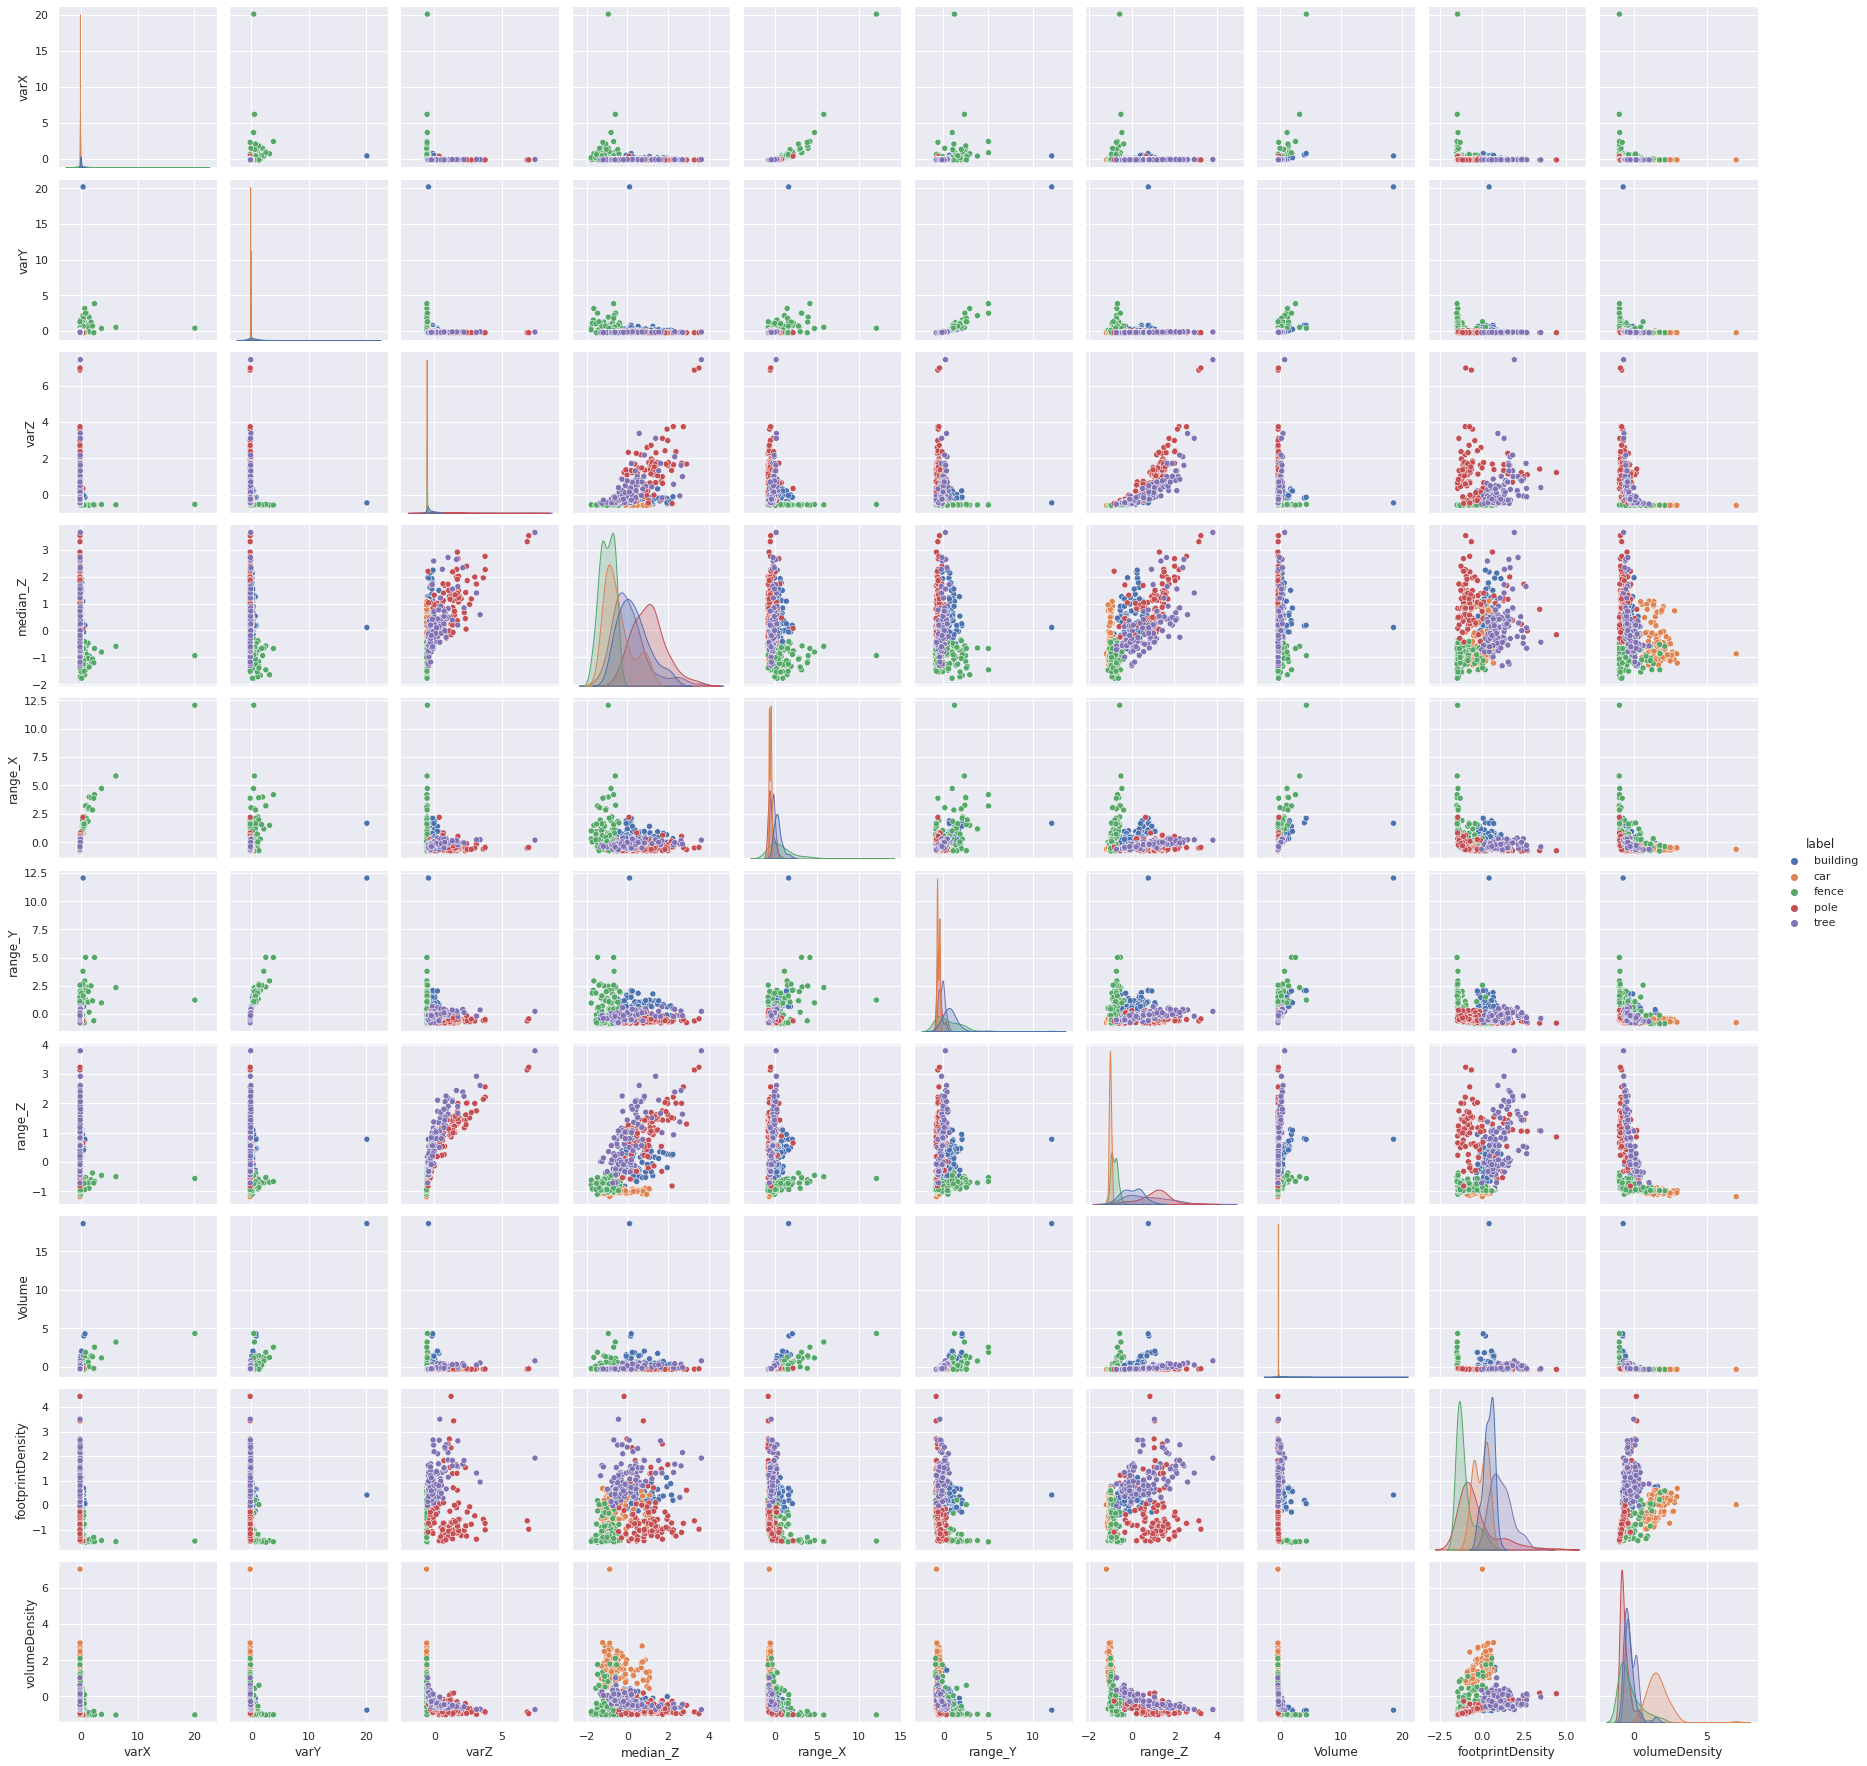

In [6]:
standardFeatureDF = (featureDF.iloc[:,:-1] - featureDF.iloc[:,:-1].mean() ) / featureDF.iloc[:,:-1].std()

# standardFeatureDF.label = featureDF.label
standardFeatureDF = standardFeatureDF.join(other=featureDF.label ,on='fileNo')
# standardFeatureDF
sns.pairplot(data=standardFeatureDF, hue="label")

# Clustering Algorithms
note: already loaded the featureDF and standardised in the cell above

## K-Means clustering

In [ ]:


def k_means():
    """
    summary: this function is not yet ready
    """
    pass

In [ ]:
k_means?

## Heirarchical clustering

This [ref was nice](https://www.section.io/engineering-education/hierarchical-clustering-in-python/) for heirarchical clustering understanding
Some other sources:
* [Statquest](https://www.youtube.com/watch?v=7xHsRkOdVwo&ab_channel=StatQuestwithJoshStarmer)
* Penn state [pseudo code](https://online.stat.psu.edu/stat508/lesson/12/12.7)
* pseudo code from [researchgate](https://www.researchgate.net/figure/The-hierarchical-clustering-algorithm-in-pseudocode_fig1_202144697)
* towards data science article to do [step by step](https://towardsdatascience.com/breaking-down-the-agglomerative-clustering-process-1c367f74c7c2) {this is a good one to follow}
* another one [for theory](https://towardsdatascience.com/machine-learning-algorithms-part-12-hierarchical-agglomerative-clustering-example-in-python-1e18e0075019)
* similar [theory as above](https://www.geeksforgeeks.org/ml-hierarchical-clustering-agglomerative-and-divisive-clustering/)
* real good [step by step explaination](https://medium.com/@darkprogrammerpb/agglomerative-hierarchial-clustering-from-scratch-ec50e14c3826), also the [github code](https://github.com/Darkprogrammerpb/DeepLearningProjects/blob/master/Project40/agglomerative_hierarchial_clustering/Hierarchial%20Agglomerative%20clustering.ipynb)

### To Think in heirarchical clustering:
* Which type of heirarchical clustering are we doing: lets begin with agglomerative clustering
* Within the selected type what distance metrics are we using


In [44]:

tempDF = standardFeatureDF.iloc[:,:-1].copy()

def heirarch_clust(dataDF):
    distances = eucDist(standardFeatureDF.drop('label', axis=1))
    
    pass


distMatDF = pd.DataFrame( distance_matrix(tempDF.values, tempDF.values), index = tempDF.index, columns = tempDF.index)
# distMatDF = pd.DataFrame( np.tril(distMatDF),  index = tempDF.index, columns = tempDF.index)
distMatDF = distMatDF.where(distMatDF!=0, np.nan)
distMatDF

fileNo,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
fileNo,,,,,,,,,,,,,,,,,,,,,
0,NaN,2.574501,2.144393,2.209737,3.472498,1.841868,3.026131,2.644947,2.832788,2.338606,...,2.195088,4.039945,2.608767,2.877201,3.276568,3.311645,3.365487,2.687808,2.490228,2.244077
1,2.574501,NaN,2.271657,2.559484,2.235959,1.487359,1.681056,2.973740,1.745451,2.152603,...,0.791817,4.354254,1.760594,1.540615,1.490205,2.410368,3.107862,0.888874,2.743983,0.747427
2,2.144393,2.271657,NaN,0.504025,1.797943,1.492353,3.116801,1.654982,1.265895,0.865140,...,2.384103,3.464734,1.789230,2.202106,2.944085,3.189730,2.708992,2.220230,2.185784,1.946434
3,2.209737,2.559484,0.504025,NaN,1.852994,1.694753,3.324740,1.590265,1.543798,1.177028,...,2.672125,3.666159,2.131088,2.626599,3.350580,3.593042,3.073367,2.588518,2.540965,2.307101
4,3.472498,2.235959,1.797943,1.852994,NaN,1.997464,2.892962,2.064431,0.986553,1.732406,...,2.715811,4.611560,2.472422,2.585656,3.051772,3.681593,3.642196,2.429393,3.445879,2.365583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,3.311645,2.410368,3.189730,3.593042,3.681593,3.078434,2.688887,3.983859,3.099673,3.256381,...,2.487018,3.600597,2.497476,1.707411,1.244607,NaN,1.829312,2.255954,2.291556,2.218532
496,3.365487,3.107862,2.708992,3.073367,3.642196,3.299543,3.734616,3.839151,3.074288,2.962046,...,3.139637,1.922267,2.033782,1.884151,2.368662,1.829312,NaN,2.629444,1.297173,2.635838
497,2.687808,0.888874,2.220230,2.588518,2.429393,1.678229,2.105424,3.135257,1.779044,2.035366,...,0.938587,3.761611,1.124038,0.966225,1.304141,2.255954,2.629444,NaN,2.184265,0.544401


In [58]:
# distMatDF.where(distMatDF == distMatDF.min(skipna=True)).sum()

standardFeatureDF.iloc[142]
# standardFeatureDF.iloc[151]

varX               -0.164538
varY               -0.229431
varZ               -0.569521
median_Z           -1.046611
range_X            -0.478933
range_Y            -0.744622
range_Z            -1.016231
Volume             -0.301318
footprintDensity   -0.467075
volumeDensity       0.852412
label                    car
Name: 142, dtype: object

In [30]:
# get the minimum values and their indices
vals = distMatDF.min(skipna=True)
idVals = distMatDF.idxmin(skipna=True)

print(vals.min(), vals.idxmin()) # GIVES US THE MINIMUM VALUE and the index at which this was found in the vals series
print(idVals.iloc[vals.idxmin()]) # this is to print the index of the index found, so these are the same clusters now


0.08375377390887534 142
151.0



devise new distance matrix and then repeat the sequence:
### TODO: 
* linkage between the clusters
* updation of the distance matrix

clusters to be made:
`vals.idxmin()` and `idVals.iloc[vals.idxmin()]`

In [116]:
a=pd.Series([1,2,3,4], index=[1,2,3,4])
b=pd.Series([2,-2,-3,5], index=[1,2,3,5])
np.minimum(a,b)
# pd.concat([a,b], axis=1).min(axis=1)

# print(distMatDF.loc[[123,134]].min())
distMatDF.loc[ind_to_pop]
# ind_to_pop

fileNo,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
fileNo,,,,,,,,,,,,,,,,,,,,,
151.0,3.453122,1.623481,3.528075,3.720277,3.158734,2.449078,1.650395,3.880079,2.889112,3.300761,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142.0,3.505177,1.664391,3.584441,3.780562,3.209808,2.514727,1.649538,3.941706,2.943181,3.360491,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
singleLink_minRow.drop(ind_to_pop, axis=1).min()

fileNo
140    1.247339
141    0.978600
143    1.183638
144    1.251945
145    0.556149
146    0.504672
147    2.068946
148    2.248452
149    1.934577
150    1.922855
152         NaN
153         NaN
154         NaN
155         NaN
156         NaN
157         NaN
dtype: float64

In [142]:


tempDF = standardFeatureDF.iloc[:,:-1].copy()

progression = [[i] for i in range(len(standardFeatureDF))]
samples     = [[list(standardFeatureDF.iloc[i, :-1])] for i in range(len(standardFeatureDF))]
m = len(samples)
# distcal  = Distance_computation_grid()

distMatDF = pd.DataFrame( distance_matrix(tempDF.values, tempDF.values), index = tempDF.index, columns = tempDF.index)
distMatDF = pd.DataFrame( np.tril(distMatDF),  index = tempDF.index, columns = tempDF.index)
distMatDF = distMatDF.where(distMatDF!=0, np.nan)
    
m=2
while m>1:
    # cluster size
    print(f"Total sample = {m}")
    # compute distances

    # get indices with min dist
    vals = distMatDF.min(skipna=True)
    idVals = distMatDF.idxmin(skipna=True)

    # print(vals.min(), vals.idxmin()) # GIVES US THE MINIMUM VALUE and the index at which this was found in the vals series
    # print(idVals.iloc[vals.idxmin()])
    
    ind_to_pop = [idVals.iloc[vals.idxmin()] , vals.idxmin()]
    print(ind_to_pop)

    # update distmatrix at some point

    # add updated new row, col to dist mat  
    # this updated row is basically the minimum of the two eliminated rows
    singleLink_minRow = distMatDF.loc[ind_to_pop].drop(ind_to_pop, axis=1).min()

    # pop row and col from dist mat
    distMatDF = distMatDF.drop(ind_to_pop, axis=0).drop(ind_to_pop, axis=1)
    print(len(distMatDF),len(distMatDF.columns ))


    
    # min distance from other points
    distMatDF.loc[str(ind_to_pop), :] = singleLink_minRow
    # distMatDF.append(singleLink_minRow)
    # update value of m
    m-=1

# sample_ind_needed = np.where(Distance_mat==Distance_mat.min())[0]
# value_to_add      = samples.pop(sample_ind_needed[1])
# samples[sample_ind_needed[0]].append(value_to_add)

# print('Cluster Node 1                   :-',progression[sample_ind_needed[0]])
# print('Cluster Node 2                   :-',progression[sample_ind_needed[1]])

# progression[sample_ind_needed[0]].append(progression[sample_ind_needed[1]])
# progression[sample_ind_needed[0]] = [progression[sample_ind_needed[0]]]
# v = progression.pop(sample_ind_needed[1])
# m = len(samples)

# print('Progression(Current Sample)      :-',progression)
# print('Cluster attained                 :-',progression[sample_ind_needed[0]])
# print('Sample size after clustering     :-',m)
# print('\n')

Total sample = 2
[151.0, 142]
498 498


## DBSCAN